Please upload both source and target datasets (.txt)


Saving single-video-TEST1-M1_M7000_Before_HO.txt to single-video-TEST1-M1_M7000_Before_HO (2).txt
Saving single-video-TEST1-M1_M7001_Before_HO.txt to single-video-TEST1-M1_M7001_Before_HO (2).txt
Training on source (M7000)...
Epoch 1: Val Loss = 0.0299
Epoch 2: Val Loss = 0.0277
Epoch 3: Val Loss = 0.0255
Epoch 4: Val Loss = 0.0235
Epoch 5: Val Loss = 0.0215
Epoch 6: Val Loss = 0.0195
Epoch 7: Val Loss = 0.0177
Epoch 8: Val Loss = 0.0159
Epoch 9: Val Loss = 0.0142
Epoch 10: Val Loss = 0.0127
Epoch 11: Val Loss = 0.0112
Epoch 12: Val Loss = 0.0098
Epoch 13: Val Loss = 0.0085
Epoch 14: Val Loss = 0.0073
Epoch 15: Val Loss = 0.0062
Epoch 16: Val Loss = 0.0052
Epoch 17: Val Loss = 0.0043
Epoch 18: Val Loss = 0.0036
Epoch 19: Val Loss = 0.0029
Epoch 20: Val Loss = 0.0023

Fine-tuning on target (M7001)...
Epoch 1: Val Loss = 0.0016
Epoch 2: Val Loss = 0.0010
Epoch 3: Val Loss = 0.0006
Epoch 4: Val Loss = 0.0003
Epoch 5: Val Loss = 0.0002
Epoch 6: Val Loss = 0.0001
Epoch 7: Val Loss = 0.0002


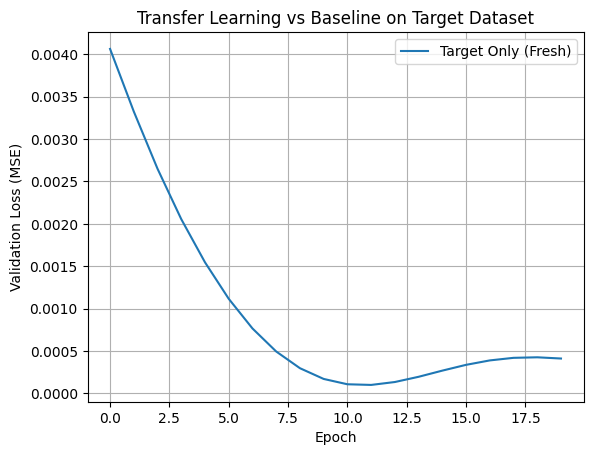

In [ ]:
# Install & import required packages
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Upload files
from google.colab import files
print("Please upload both source and target datasets (.txt)")
uploaded = files.upload()

# Load and preprocess function
def load_and_preprocess(filepath, features, target):
    df = pd.read_csv(filepath, sep='\t', low_memory=False)
    df = df[features + [target]].dropna()
    X = df[features].values
    y = df[target].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Select features and target
features = [
    'PCell Serving SS-RSRP [dBm]', 'PCell Serving SS-RSRQ [dB]',
    'PCell Serving SS-SINR [dB]', 'PCell Pathloss [dB]',
    'PCell CQI', 'PCell TA', 'PCell PUSCH Power [dBm]',
    'API GPS Info Speed', 'API GPS Info Altitude'
]
target = 'HO Duration [sec]'

# File names (update if needed)
source_file = "single-video-TEST1-M1_M7000_Before_HO.txt"
target_file = "single-video-TEST1-M1_M7001_Before_HO.txt"

# Load both datasets
X_src_train, X_src_test, y_src_train, y_src_test = load_and_preprocess(source_file, features, target)
X_tgt_train, X_tgt_test, y_tgt_train, y_tgt_test = load_and_preprocess(target_file, features, target)

# Convert to DataLoaders
def to_loader(X_train, y_train, X_test, y_test, batch_size=32):
    return (
        DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                 torch.tensor(y_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True),
        DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                 torch.tensor(y_test, dtype=torch.float32)), batch_size=batch_size)
    )

src_train_loader, src_test_loader = to_loader(X_src_train, y_src_train, X_src_test, y_src_test)
tgt_train_loader, tgt_test_loader = to_loader(X_tgt_train, y_tgt_train, X_tgt_test, y_tgt_test)

# Define LSTM regression model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # add time dimension
        _, (hn, _) = self.lstm(x)
        return self.regressor(hn[-1])

# Training function
def train(model, train_loader, val_data, epochs=20):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    val_losses = []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb).squeeze()
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_preds = model(val_data[0]).squeeze()
            val_loss = criterion(val_preds, val_data[1]).item()
            val_losses.append(val_loss)
            print(f"Epoch {epoch+1}: Val Loss = {val_loss:.4f}")
    return val_losses

# Prepare input tensors for validation
X_tgt_test_tensor = torch.tensor(X_tgt_test, dtype=torch.float32)
y_tgt_test_tensor = torch.tensor(y_tgt_test, dtype=torch.float32)

# Step 1: Pretrain on source
print("Training on source (M7000)...")
model_pretrained = LSTMModel(input_dim=len(features))
train(model_pretrained, src_train_loader, (X_tgt_test_tensor, y_tgt_test_tensor))

# Step 2: Fine-tune on target
print("\nFine-tuning on target (M7001)...")
train(model_pretrained, tgt_train_loader, (X_tgt_test_tensor, y_tgt_test_tensor))

# Step 3: Train another model from scratch on target
print("\nTraining baseline (from scratch on target)...")
model_fresh = LSTMModel(input_dim=len(features))
baseline_loss = train(model_fresh, tgt_train_loader, (X_tgt_test_tensor, y_tgt_test_tensor))

# Plot comparison
plt.plot(baseline_loss, label="Target Only (Fresh)")
plt.title("Transfer Learning vs Baseline on Target Dataset")
plt.ylabel("Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Draw comparision
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate a model on test set and print metrics
def evaluate_model(model, name="Model"):
    model.eval()
    with torch.no_grad():
        preds = model(X_tgt_test_tensor).squeeze().numpy()
        actual = y_tgt_test_tensor.numpy()

    mae = mean_absolute_error(actual, preds)
    rmse = np.sqrt(mean_squared_error(actual, preds))
    r2 = r2_score(actual, preds)

    print(f"{name} Evaluation Metrics:")
    print(f"  ▸ MAE  = {mae:.6f}")
    print(f"  ▸ RMSE = {rmse:.6f}")
    print(f"  ▸ R²    = {r2:.6f}")
    return preds, actual

# Run evaluations
preds_transfer, actual_transfer = evaluate_model(model_pretrained, "Transfer Learned Model (M7000 → M7001)")
preds_baseline, actual_baseline = evaluate_model(model_fresh, "Baseline Model (M7001 Only)")


Transfer Learned Model (M7000 → M7001) Evaluation Metrics:
  ▸ MAE  = 0.016047
  ▸ RMSE = 0.017733
  ▸ R²    = -649.645386
Baseline Model (M7001 Only) Evaluation Metrics:
  ▸ MAE  = 0.019095
  ▸ RMSE = 0.020276
  ▸ R²    = -849.635254


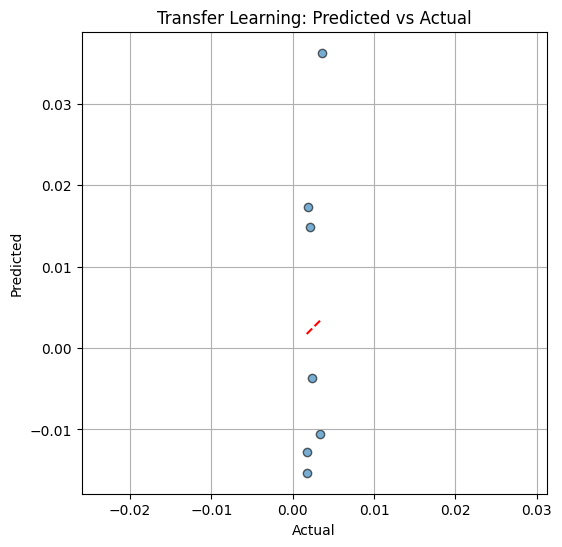

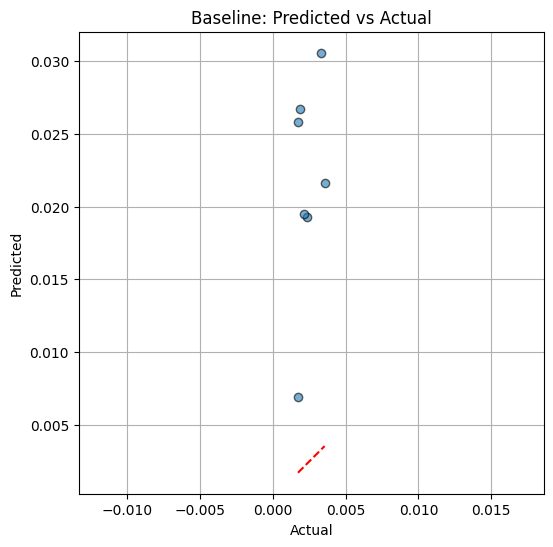

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(preds, actuals, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(actuals, preds, alpha=0.6, edgecolors='k')
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.axis('equal')
    plt.show()

plot_predictions(preds_transfer, actual_transfer, "Transfer Learning: Predicted vs Actual")
plot_predictions(preds_baseline, actual_baseline, "Baseline: Predicted vs Actual")



In [ ]:
# Train/test split with only 20% of target data
X_small, _, y_small, _ = train_test_split(X_tgt_train, y_tgt_train, test_size=0.8, random_state=42)
small_loader, _ = to_loader(X_small, y_small, X_tgt_test, y_tgt_test)

# Fine-tune transfer model with smaller data
print("Fine-tuning with only 20% target data...")
train(model_pretrained, small_loader, (X_tgt_test_tensor, y_tgt_test_tensor))
evaluate_model(model_pretrained, "Transfer Learned Model (20% Target Data)")


Fine-tuning with only 20% target data...
Epoch 1: Val Loss = 0.0004
Epoch 2: Val Loss = 0.0004
Epoch 3: Val Loss = 0.0004
Epoch 4: Val Loss = 0.0004
Epoch 5: Val Loss = 0.0003
Epoch 6: Val Loss = 0.0003
Epoch 7: Val Loss = 0.0003
Epoch 8: Val Loss = 0.0004
Epoch 9: Val Loss = 0.0004
Epoch 10: Val Loss = 0.0004
Epoch 11: Val Loss = 0.0004
Epoch 12: Val Loss = 0.0004
Epoch 13: Val Loss = 0.0004
Epoch 14: Val Loss = 0.0003
Epoch 15: Val Loss = 0.0003
Epoch 16: Val Loss = 0.0003
Epoch 17: Val Loss = 0.0003
Epoch 18: Val Loss = 0.0004
Epoch 19: Val Loss = 0.0004
Epoch 20: Val Loss = 0.0004
Transfer Learned Model (20% Target Data) Evaluation Metrics:
  ▸ MAE  = 0.013655
  ▸ RMSE = 0.018994
  ▸ R²    = -745.505554


(array([ 0.00233851,  0.04407783, -0.00403447,  0.02091874, -0.00381707,
         0.00493164,  0.02333008], dtype=float32),
 array([0.0033    , 0.00355556, 0.00172727, 0.0019    , 0.00172727,
        0.002375  , 0.00211111], dtype=float32))

Transfer Learning for HO duration!!

In [ ]:
# Upload 3 telemetry files (Before, During, After HO)
from google.colab import files
print("Upload 3 M7000 files (Before, During, After)")
uploaded = files.upload()

import pandas as pd
import numpy as np

# Dynamically combine uploaded files
dfs = []
for fname in uploaded:
    if "Before" in fname:
        phase = "before"
    elif "During" in fname:
        phase = "during"
    elif "After" in fname:
        phase = "after"
    else:
        continue  # ignore irrelevant files
    df = pd.read_csv(fname, sep="\t", low_memory=False)
    df["Phase"] = phase
    df["Device"] = "M7000"
    dfs.append(df)

df_m7000 = pd.concat(dfs, ignore_index=True)
print(f"Loaded combined M7000 dataset with {len(df_m7000)} rows.")


Upload 3 M7000 files (Before, During, After)


Saving single-video-TEST1-M1_M7000_After_HO.txt to single-video-TEST1-M1_M7000_After_HO (2).txt
Saving single-video-TEST1-M1_M7000_Before_HO.txt to single-video-TEST1-M1_M7000_Before_HO (3).txt
Saving single-video-TEST1-M1_M7000_During_HO.txt to single-video-TEST1-M1_M7000_During_HO (1).txt
Loaded combined M7000 dataset with 354 rows.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight

# Required columns
features = [
    "PCell Serving SS-RSRP [dBm]",
    "PCell Serving SS-RSRQ [dB]",
    "PCell Serving SS-SINR [dB]",
    "PCell Pathloss [dB]",
    "API GPS Info Speed"
]
target = "HO Duration [sec]"

# Clean and engineer
df = df_m7000[features + [target]].dropna()
df = df[df[target] > 0]
df["RSRP_minus_Pathloss"] = df["PCell Serving SS-RSRP [dBm]"] - df["PCell Pathloss [dB]"]
df["SINR_by_Speed"] = df["PCell Serving SS-SINR [dB]"] / (df["API GPS Info Speed"] + 1)
df["log_SINR"] = np.log1p(np.clip(df["PCell Serving SS-SINR [dB]"], a_min=-1, a_max=None))
df["log_Pathloss"] = np.log1p(np.clip(df["PCell Pathloss [dB]"], a_min=0, a_max=None))
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Final input/output
X_df = df[[
    "PCell Serving SS-RSRP [dBm]",
    "PCell Serving SS-RSRQ [dB]",
    "API GPS Info Speed",
    "RSRP_minus_Pathloss",
    "SINR_by_Speed",
    "log_SINR",
    "log_Pathloss"
]]
X = X_df.values
y = df[target].values

# Stratified binning with fallback
success = False
for bins in range(5, 1, -1):
    try:
        cuts = np.quantile(y, q=np.linspace(0, 1, bins))
        y_bins = np.digitize(y, cuts)
        if all(np.bincount(y_bins) >= 2):
            success = True
            break
    except:
        continue

from sklearn.preprocessing import StandardScaler, MinMaxScaler
y_log = np.log1p(np.clip(y, a_min=0, a_max=None))
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_log.reshape(-1, 1))
x_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)

if success:
    print(f"Using stratified split with {bins - 1} bins")
    X_train, X_val, y_train, y_val, yb_train, yb_val = train_test_split(
        X_scaled, y_scaled, y_bins, test_size=0.2, stratify=y_bins, random_state=42)
    sample_weights = compute_sample_weight(class_weight='balanced', y=yb_train)
else:
    print("Not enough data for stratified bins — using random split")
    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
    sample_weights = np.ones_like(y_train.squeeze())


Not enough data for stratified bins — using random split


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import numpy as np

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.squeeze(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.squeeze(), dtype=torch.float32)
sample_weights_tensor = torch.tensor(sample_weights, dtype=torch.float32)

# Data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=WeightedRandomSampler(sample_weights_tensor, len(sample_weights_tensor), replacement=True))
val_loader = DataLoader(val_dataset, batch_size=32)

# LSTM model
class TransferLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        x = x.unsqueeze(1)
        _, (hn, _) = self.lstm(x)
        return self.regressor(hn[-1])

# Training function
def train_model(model, train_loader, val_loader, epochs=30):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        batch_loss = []
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb).squeeze()
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        train_losses.append(np.mean(batch_loss))

        # Validation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_tensor).squeeze()
            val_loss = loss_fn(val_preds, y_val_tensor).item()
            val_losses.append(val_loss)
        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_loss:.4f}")

    return model

# Train LSTM model on M7000 data
input_dim = X_train.shape[1]
source_model = TransferLSTM(input_dim=input_dim)
source_model = train_model(source_model, train_loader, val_loader, epochs=30)


Epoch 1: Train Loss = 0.3093, Val Loss = 0.2053
Epoch 2: Train Loss = 0.2233, Val Loss = 0.1775
Epoch 3: Train Loss = 0.1660, Val Loss = 0.1500
Epoch 4: Train Loss = 0.1421, Val Loss = 0.1246
Epoch 5: Train Loss = 0.1164, Val Loss = 0.0999
Epoch 6: Train Loss = 0.1020, Val Loss = 0.0757
Epoch 7: Train Loss = 0.0711, Val Loss = 0.0537
Epoch 8: Train Loss = 0.0413, Val Loss = 0.0357
Epoch 9: Train Loss = 0.0299, Val Loss = 0.0240
Epoch 10: Train Loss = 0.0241, Val Loss = 0.0177
Epoch 11: Train Loss = 0.0330, Val Loss = 0.0157
Epoch 12: Train Loss = 0.0276, Val Loss = 0.0159
Epoch 13: Train Loss = 0.0214, Val Loss = 0.0175
Epoch 14: Train Loss = 0.0236, Val Loss = 0.0197
Epoch 15: Train Loss = 0.0254, Val Loss = 0.0203
Epoch 16: Train Loss = 0.0196, Val Loss = 0.0196
Epoch 17: Train Loss = 0.0175, Val Loss = 0.0188
Epoch 18: Train Loss = 0.0210, Val Loss = 0.0175
Epoch 19: Train Loss = 0.0217, Val Loss = 0.0160
Epoch 20: Train Loss = 0.0180, Val Loss = 0.0155
Epoch 21: Train Loss = 0.0211

In [ ]:
print("Upload M7001 dataset (Before, During, After)...")
uploaded = files.upload()

# Load and combine target data
dfs_target = []
for fname in uploaded:
    if any(phase in fname for phase in ["Before", "During", "After"]):
        df = pd.read_csv(fname, sep="\t")
        dfs_target.append(df)

df_m7001 = pd.concat(dfs_target, ignore_index=True)

# Clean + Feature Engineering (same as M7000)
df = df_m7001[features + [target]].dropna()
df = df[df[target] > 0]
df["RSRP_minus_Pathloss"] = df["PCell Serving SS-RSRP [dBm]"] - df["PCell Pathloss [dB]"]
df["SINR_by_Speed"] = df["PCell Serving SS-SINR [dB]"] / (df["API GPS Info Speed"] + 1)
df["log_SINR"] = np.log1p(np.clip(df["PCell Serving SS-SINR [dB]"], a_min=-1, a_max=None))
df["log_Pathloss"] = np.log1p(np.clip(df["PCell Pathloss [dB]"], a_min=0, a_max=None))
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

X_tgt = df[X_df.columns].values
y_tgt = df[target].values
y_log_tgt = np.log1p(np.clip(y_tgt, a_min=0, a_max=None))
y_scaled_tgt = y_scaler.transform(y_log_tgt.reshape(-1, 1))
X_scaled_tgt = x_scaler.transform(X_tgt)

X_train_tgt, X_val_tgt, y_train_tgt, y_val_tgt = train_test_split(X_scaled_tgt, y_scaled_tgt, test_size=0.2, random_state=42)
train_loader_tgt = DataLoader(TensorDataset(torch.tensor(X_train_tgt, dtype=torch.float32), torch.tensor(y_train_tgt.squeeze(), dtype=torch.float32)), batch_size=32, shuffle=True)
val_loader_tgt = DataLoader(TensorDataset(torch.tensor(X_val_tgt, dtype=torch.float32), torch.tensor(y_val_tgt.squeeze(), dtype=torch.float32)), batch_size=32)

# Fine-tune pretrained model
print("Fine-tuning on M7001...")
source_model = train_model(source_model, train_loader_tgt, val_loader_tgt, epochs=20)


Upload M7001 dataset (Before, During, After)...


Saving single-video-TEST1-M1_M7001_After_HO.txt to single-video-TEST1-M1_M7001_After_HO (2).txt
Saving single-video-TEST1-M1_M7001_Before_HO.txt to single-video-TEST1-M1_M7001_Before_HO (3).txt
Saving single-video-TEST1-M1_M7001_During_HO.txt to single-video-TEST1-M1_M7001_During_HO (1).txt
Fine-tuning on M7001...
Epoch 1: Train Loss = 0.0192, Val Loss = 0.0168
Epoch 2: Train Loss = 0.0213, Val Loss = 0.0196
Epoch 3: Train Loss = 0.0182, Val Loss = 0.0158
Epoch 4: Train Loss = 0.0171, Val Loss = 0.0140
Epoch 5: Train Loss = 0.0180, Val Loss = 0.0139
Epoch 6: Train Loss = 0.0168, Val Loss = 0.0152
Epoch 7: Train Loss = 0.0169, Val Loss = 0.0167
Epoch 8: Train Loss = 0.0163, Val Loss = 0.0164
Epoch 9: Train Loss = 0.0160, Val Loss = 0.0151
Epoch 10: Train Loss = 0.0169, Val Loss = 0.0152
Epoch 11: Train Loss = 0.0159, Val Loss = 0.0152
Epoch 12: Train Loss = 0.0163, Val Loss = 0.0158


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch 13: Train Loss = 0.0157, Val Loss = 0.0158
Epoch 14: Train Loss = 0.0161, Val Loss = 0.0151
Epoch 15: Train Loss = 0.0152, Val Loss = 0.0154
Epoch 16: Train Loss = 0.0154, Val Loss = 0.0152
Epoch 17: Train Loss = 0.0162, Val Loss = 0.0151
Epoch 18: Train Loss = 0.0153, Val Loss = 0.0139
Epoch 19: Train Loss = 0.0154, Val Loss = 0.0142
Epoch 20: Train Loss = 0.0147, Val Loss = 0.0150


Evaluation on Target (M7001):
  ▸ MAE  = 0.0013 sec
  ▸ RMSE = 0.0018 sec
  ▸ R²    = 0.7617


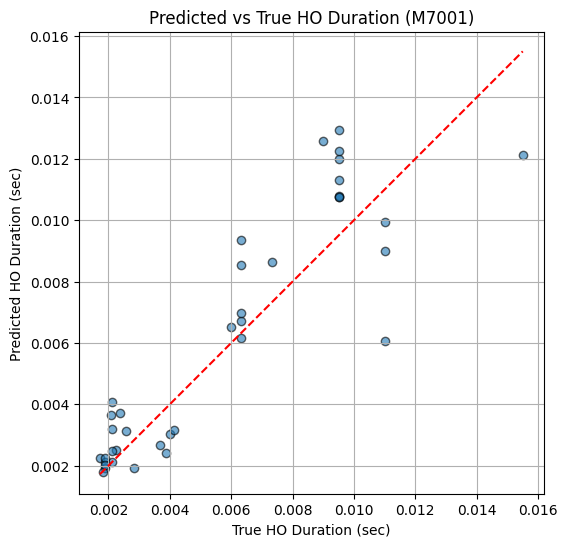

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Evaluate on M7001 test set
source_model.eval()
with torch.no_grad():
    y_pred_scaled = source_model(torch.tensor(X_val_tgt, dtype=torch.float32)).squeeze().numpy()
    y_true_scaled = y_val_tgt.squeeze()

# Inverse transform predictions
y_pred = np.expm1(y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))).flatten()
y_true = np.expm1(y_scaler.inverse_transform(y_true_scaled.reshape(-1, 1))).flatten()

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Evaluation on Target (M7001):")
print(f"  ▸ MAE  = {mae:.4f} sec")
print(f"  ▸ RMSE = {rmse:.4f} sec")
print(f"  ▸ R²    = {r2:.4f}")

# Plot Predicted vs True
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("True HO Duration (sec)")
plt.ylabel("Predicted HO Duration (sec)")
plt.title("Predicted vs True HO Duration (M7001)")
plt.grid(True)
plt.axis("equal")
plt.show()
